In [1]:
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [2]:
url_sd = "https://www.ratemyprofessors.com/search/professors/1079?q=*"
url_davis = "https://www.ratemyprofessors.com/search/professors/1073?q=*"
url_berkeley = "https://www.ratemyprofessors.com/search/professors/1072?q=*"
url_ucla = "https://www.ratemyprofessors.com/search/professors/1075?q=*"
url_irvine = "https://www.ratemyprofessors.com/search/professors/1074?q=*"
url_sb = "https://www.ratemyprofessors.com/search/professors/1077?q=*"
url_riverside = "https://www.ratemyprofessors.com/search/professors/1076?q=*"
url_merced = "https://www.ratemyprofessors.com/search/professors/4767?q=*"
url_santa_cruz = "https://www.ratemyprofessors.com/search/professors/1078?q=*"

school_ids = ["1079", "1073", "1072", "1075", "1074", "1077", "1076", "4767", "1078"]
base_url = "https://www.ratemyprofessors.com/search/professors/"
complete_urls = [f"{base_url}{school_id}?q=*" for school_id in school_ids]

In [7]:
import time
import uuid
import os
import hashlib
import pandas as pd
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

def scrape_rmp(url, school_name):
    unique_dir = f"/tmp/chrome-user-data-{uuid.uuid4().hex}"
    os.makedirs(unique_dir, exist_ok=True)

    options = Options()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument(f"--user-data-dir={unique_dir}")

    driver = webdriver.Chrome(options=options)
    driver.get(url)

    try:
        WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.XPATH, "//h1[@data-testid='pagination-header-main-results']"))
        )
    except Exception as e:
        print("Initial page load error:", e)

    pbar = tqdm(unit="clicks", desc=f"{school_name}: Clicking 'Show More'")
    while True:
        try:
            btn = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, "//button[contains(text(), 'Show More')]"))
            )
            driver.execute_script("arguments[0].click();", btn)
            pbar.update(1)
            time.sleep(0.5)
        except Exception:
            print("[DEBUG] No more 'Show More' button or stale reference encountered.")
            break
    pbar.close()

    data = []
    index = 0
    while True:
        try:
            cards = driver.find_elements(By.CSS_SELECTOR, "a.TeacherCard__StyledTeacherCard-syjs0d-0")
            if index >= len(cards):
                break

            card = cards[index]
            driver.execute_script("arguments[0].scrollIntoView();", card)
            time.sleep(0.5)
            
            name_elem = card.find_element(By.CSS_SELECTOR, "div.CardName__StyledCardName-sc-1gyrgim-0")
            full_name = name_elem.text.strip()
            anonymized_name = hashlib.sha256(full_name.encode()).hexdigest()[:8]

            rating_elem = card.find_element(By.CSS_SELECTOR, "div.CardNumRating__CardNumRatingNumber-sc-17t4b9u-2")
            avg_rating = rating_elem.text.strip()

            count_elem = card.find_element(By.CSS_SELECTOR, "div.CardNumRating__CardNumRatingCount-sc-17t4b9u-3")
            num_ratings = count_elem.text.replace("ratings", "").strip()

            dept_elem = card.find_element(By.CSS_SELECTOR, "div.CardSchool__Department-sc-19lmz2k-0")
            department = dept_elem.text.strip()

            driver.execute_script("arguments[0].click();", card)
            time.sleep(2)

            reviews = []
            tags = []
            
            try:
                review_elements = driver.find_elements(By.CSS_SELECTOR, "div.Comments__StyledComments-dzzyvm-0")
                reviews = [review.text.strip() for review in review_elements]

                tag_elements = driver.find_elements(By.CSS_SELECTOR, "span.Tag-bsuhb8-0")
                tags = [tag.text.strip() for tag in tag_elements]
            except Exception:
                pass

            data.append({
                "Professor": anonymized_name,
                "Average Rating": avg_rating,
                "Num Ratings": num_ratings,
                "Department": department,
                "School": school_name,
                "Reviews": reviews,
                "Tags": tags
            })

            driver.back()
            time.sleep(2)
            index += 1
        except Exception as e:
            print(f"Skipping a card in {school_name} due to error:", e)
            index += 1
            driver.back()
            time.sleep(2)

    driver.quit()
    return pd.DataFrame(data)

school_names = {
    "1079": "UC San Diego",
    "1073": "UC Davis",
    "1072": "UC Berkeley",
    "1075": "UCLA",
    "1074": "UC Irvine",
    "1077": "UC Santa Barbara",
    "1076": "UC Riverside",
    "4767": "UC Merced",
    "1078": "UC Santa Cruz"
}
school_ids = ["1079", "1073", "1072", "1075", "1074", "1077", "1076", "4767", "1078"]
did_ids = ['2889', '140', '140', '140', '140', '140', '140', '140', '140']  # Matched by index

# Create a mapping of school ID to department ID (did)
complete_urls = {sid: f"{base_url}{sid}?q=*&did={did_ids[i]}" for i, sid in enumerate(school_ids)}

dfs = []
for sid, url in complete_urls.items():
    school_name = school_names.get(sid, f"School {sid}")
    print(f"[INFO] Scraping data for {school_name} from {url}")
    df_school = scrape_rmp(url, school_name)
    print(df_school.head())
    print(f"[INFO] Scraped {len(df_school)} records for {school_name}")
    dfs.append(df_school)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Total records scraped: {len(df_all)}")
print(df_all.head(15))

## HAD TO STOP AT UCI BECAUSE IT TOOK 40 MIN TO RUN!!


[INFO] Scraping data for UC San Diego from https://www.ratemyprofessors.com/search/professors/1079?q=*&did=2889


UC San Diego: Clicking 'Show More': 1clicks [00:06,  6.24s/clicks]

[DEBUG] No more 'Show More' button or stale reference encountered.


  Professor Average Rating Num Ratings    Department        School  \
0  a968b33d            2.5          13  Data Science  UC San Diego   
1  11b6fcc2            3.7          13  Data Science  UC San Diego   
2  9c6f5334            5.0           2  Data Science  UC San Diego   
3  3ed2b676            3.3         106  Data Science  UC San Diego   
4  aed83b0e            4.6           8  Data Science  UC San Diego   

                                             Reviews Tags  
0  [Prof. Salimi is the worst I've had. Lectures ...   []  
1  [The easiest CS class you will ever take. 5 ho...   []  
2  [Professor Hao really cares about teaching, an...   []  
3  [Great professor, even though attendance not m...   []  
4  [I can't say he's an unfair or hard professor,...   []  
[INFO] Scraped 16 records for UC San Diego
[INFO] Scraping data for UC Davis from https://www.ratemyprofessors.com/search/professors/1073?q=*&did=140


UC Davis: Clicking 'Show More': 12clicks [00:12,  1.03s/clicks]

[DEBUG] No more 'Show More' button or stale reference encountered.


  Professor Average Rating Num Ratings  Department    School  \
0  cd3aa54f            2.4         250  Statistics  UC Davis   
1  686e5a8a            3.8         211  Statistics  UC Davis   
2  d93ba308            4.7          55  Statistics  UC Davis   
3  de08aacd            3.0          33  Statistics  UC Davis   
4  a7a92166            4.5          92  Statistics  UC Davis   

                                             Reviews Tags  
0  [I have him right now, and he's the worst prof...   []  
1  [Dr. Whitener is the BEST; she provides every ...   []  
2  [Okay, this has got to be the worst case of "I...   []  
3  [They are truly the goat. They have made their...   []  
4  [Prof Anderes is hands down the best professor...   []  
[INFO] Scraped 100 records for UC Davis
[INFO] Scraping data for UC Berkeley from https://www.ratemyprofessors.com/search/professors/1072?q=*&did=140


UC Berkeley: Clicking 'Show More': 8clicks [00:09,  1.17s/clicks]

[DEBUG] No more 'Show More' button or stale reference encountered.


  Professor Average Rating Num Ratings  Department       School  \
0  513ab4b7            2.9          56  Statistics  UC Berkeley   
1  883a5a69            2.7         115  Statistics  UC Berkeley   
2  42182bde            5.0           2  Statistics  UC Berkeley   
3  f69d87a7            1.9          20  Statistics  UC Berkeley   
4  9b671a51            1.0           2  Statistics  UC Berkeley   

                                             Reviews Tags  
0  [Professor Trujillo is one of the most caring ...   []  
1  [he gives sooooo much homework, the class and ...   []  
2  [Jingyuan was very helpful in office hours and...   []  
3  [Horrible class, they don't teach you in class...   []  
4  [This class is a circus. There is no support o...   []  
[INFO] Scraped 69 records for UC Berkeley
[INFO] Scraping data for UCLA from https://www.ratemyprofessors.com/search/professors/1075?q=*&did=140


UCLA: Clicking 'Show More': 0clicks [00:05, ?clicks/s]

[DEBUG] No more 'Show More' button or stale reference encountered.


  Professor Average Rating Num Ratings  Department School  \
0  04785956            3.3           3  Statistics   UCLA   
1  ca86d588            4.7          38  Statistics   UCLA   
2  5391ad95            1.0           1  Statistics   UCLA   
3  b483a81d            5.0           1  Statistics   UCLA   
4  9cd4b195            5.0           1  Statistics   UCLA   

                                             Reviews Tags  
0  [Was really kind throughout the course. You co...   []  
1  [Great professor, Took his intro to stats clas...   []  
2  [Cha seems to follow a script and lacks flexib...   []  
3  [Professor Loya is the best instructor I have ...   []  
4  [So I basically failed the first time I took a...   []  
[INFO] Scraped 7 records for UCLA
[INFO] Scraping data for UC Irvine from https://www.ratemyprofessors.com/search/professors/1074?q=*&did=140


UC Irvine: Clicking 'Show More': 3clicks [00:07,  2.40s/clicks]

[DEBUG] No more 'Show More' button or stale reference encountered.


  Professor Average Rating Num Ratings  Department     School  \
0  6f6cfeba            3.5          30  Statistics  UC Irvine   
1  f582e840            2.9         247  Statistics  UC Irvine   
2  5d651a9d            4.0          75  Statistics  UC Irvine   
3  1b4869ec            2.4          10  Statistics  UC Irvine   
4  038ef70e            4.6         148  Statistics  UC Irvine   

                                             Reviews Tags  
0  [Engaging lectures, and reasonably difficult t...   []  
1  [There are lots of different parts to your gra...   []  
2  [This comment is for STATS210B, I can't find t...   []  
3  [not an engaging, clear, or educational lectur...   []  
4  [Videos are so confusing. He is saying a bunch...   []  
[INFO] Scraped 27 records for UC Irvine
[INFO] Scraping data for UC Santa Barbara from https://www.ratemyprofessors.com/search/professors/1077?q=*&did=140


UC Santa Barbara: Clicking 'Show More': 13clicks [00:12,  1.03clicks/s]

[DEBUG] No more 'Show More' button or stale reference encountered.


Skipping a card in UC Santa Barbara due to error: Message: invalid session id: session deleted as the browser has closed the connection
from disconnected: Unable to receive message from renderer
  (Session info: chrome=134.0.6998.89)
Stacktrace:
0   chromedriver                        0x0000000100d89804 cxxbridge1$str$ptr + 2785964
1   chromedriver                        0x0000000100d81ddc cxxbridge1$str$ptr + 2754692
2   chromedriver                        0x00000001008d5ea8 cxxbridge1$string$len + 92928
3   chromedriver                        0x00000001008c03d4 cxxbridge1$string$len + 4140
4   chromedriver                        0x00000001008c014c cxxbridge1$string$len + 3492
5   chromedriver                        0x00000001008bde64 chromedriver + 188004
6   chromedriver                        0x00000001008beabc chromedriver + 191164
7   chromedriver                        0x00000001008cc690 cxxbridge1$string$len + 53992
8   chromedriver                        0x00000001008e23ac cxx

InvalidSessionIdException: Message: invalid session id
Stacktrace:
0   chromedriver                        0x0000000100d89804 cxxbridge1$str$ptr + 2785964
1   chromedriver                        0x0000000100d81ddc cxxbridge1$str$ptr + 2754692
2   chromedriver                        0x00000001008d5d1c cxxbridge1$string$len + 92532
3   chromedriver                        0x00000001009106d4 cxxbridge1$string$len + 332588
4   chromedriver                        0x0000000100938f50 cxxbridge1$string$len + 498600
5   chromedriver                        0x0000000100938250 cxxbridge1$string$len + 495272
6   chromedriver                        0x00000001008a5cd8 chromedriver + 89304
7   chromedriver                        0x0000000100d4ecd4 cxxbridge1$str$ptr + 2545532
8   chromedriver                        0x0000000100d51fa0 cxxbridge1$str$ptr + 2558536
9   chromedriver                        0x0000000100d2ed04 cxxbridge1$str$ptr + 2414508
10  chromedriver                        0x0000000100d52800 cxxbridge1$str$ptr + 2560680
11  chromedriver                        0x0000000100d1fba0 cxxbridge1$str$ptr + 2352712
12  chromedriver                        0x00000001008a46d4 chromedriver + 83668
13  dyld                                0x00000001837eb154 start + 2476


In [12]:
df_all = pd.concat(dfs, ignore_index=True)
print(f"Total records scraped: {len(df_all)}")
print(df_all.head(15))

Total records scraped: 219
   Professor Average Rating Num Ratings    Department        School  \
0   a968b33d            2.5          13  Data Science  UC San Diego   
1   11b6fcc2            3.7          13  Data Science  UC San Diego   
2   9c6f5334            5.0           2  Data Science  UC San Diego   
3   3ed2b676            3.3         106  Data Science  UC San Diego   
4   aed83b0e            4.6           8  Data Science  UC San Diego   
5   4e8abdba            4.8          19  Data Science  UC San Diego   
6   fe2945d2            4.9          21  Data Science  UC San Diego   
7   80f62682            1.4          17  Data Science  UC San Diego   
8   1afbf8c1            5.0           1  Data Science  UC San Diego   
9   3aeb7052            2.0           3  Data Science  UC San Diego   
10  f373cdb8            5.0           9  Data Science  UC San Diego   
11  cc802ff3            5.0           3  Data Science  UC San Diego   
12  1b60e115            5.0           6  Data Scie

In [13]:
df_all.to_csv("uc_rmp_reviews.csv", index=False)

In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(review):
    score = analyzer.polarity_scores(review)
    return "Positive" if score['compound'] > 0.05 else "Negative" if score['compound'] < -0.05 else "Neutral"

df_all["Sentiment"] = df_all["Reviews"].apply(lambda reviews: [analyze_sentiment(r) for r in reviews])


In [44]:
df_all.head(50)

,Professor,Average Rating,Num Ratings,Department,School,Reviews,Tags,Sentiment,Rating_Category
0,a968b33d,2.5,13,Data Science,UC San Diego,[Prof. Salimi is the worst I've had. Lectures ...,[],"[Negative, Negative, Positive, Positive, Negat...",Low Rating
1,11b6fcc2,3.7,13,Data Science,UC San Diego,[The easiest CS class you will ever take. 5 ho...,[],"[Positive, Positive, Positive, Positive, Posit...",Medium Rating
2,9c6f5334,5.0,2,Data Science,UC San Diego,"[Professor Hao really cares about teaching, an...",[],"[Positive, Positive]",High Rating
3,3ed2b676,3.3,106,Data Science,UC San Diego,"[Great professor, even though attendance not m...",[],"[Positive, Positive, Positive, Positive, Posit...",Medium Rating
4,aed83b0e,4.6,8,Data Science,UC San Diego,"[I can't say he's an unfair or hard professor,...",[],"[Positive, Positive, Positive, Positive, Posit...",High Rating
5,4e8abdba,4.8,19,Data Science,UC San Diego,"[BEST PROF EVER, Very organized professor. Eas...",[],"[Positive, Positive, Positive, Positive, Posit...",High Rating
6,fe2945d2,4.9,21,Data Science,UC San Diego,[Took Practical Data Science at UM. Suraj was ...,[],"[Positive, Positive, Positive, Positive, Negat...",High Rating
7,80f62682,1.4,17,Data Science,UC San Diego,[slow in releasing participation and PA grades...,[],"[Negative, Positive, Negative, Negative, Negat...",Low Rating
8,1afbf8c1,5.0,1,Data Science,UC San Diego,[Best professor to introduce you to data scien...,[],[Positive],High Rating
9,3aeb7052,2.0,3,Data Science,UC San Diego,"[descent professor, make the lectures really i...",[],"[Positive, Negative, Positive]",Low Rating


Now I will create some plots. We might not use all of these plots, but the more the merrier.

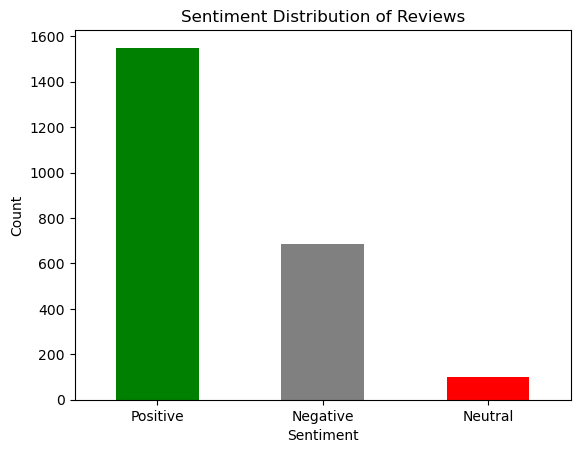

In [18]:
import matplotlib.pyplot as plt

df_sentiment_counts = df_all.explode("Sentiment")["Sentiment"].value_counts()

df_sentiment_counts.plot(kind="bar", color=["green", "gray", "red"])
plt.title("Sentiment Distribution of Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


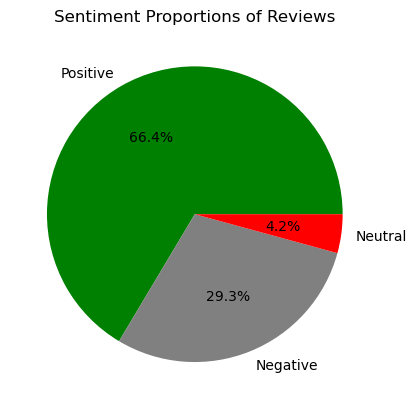

In [19]:
df_sentiment_counts.plot(kind="pie", autopct="%1.1f%%", colors=["green", "gray", "red"])
plt.title("Sentiment Proportions of Reviews")
plt.ylabel("")
plt.show()


In [51]:
import plotly.express as px

df_sentiment = df_all.explode("Sentiment")
df_sentiment_count = df_sentiment.groupby(["School", "Sentiment"]).size().reset_index(name="Count")
print(df_sentiment_count.head())

fig = px.bar(
    df_sentiment_count, 
    x="School", 
    y="Count", 
    color="Sentiment", 
    barmode="stack", 
    title="Sentiment Breakdown per University",
    labels={"Count": "Number of Reviews", "School": "University", "Sentiment": "Sentiment Type"},
    color_discrete_map={"Positive": "green", "Neutral": "gray", "Negative": "red"}
)
fig.update_layout(
    width=1000,  # Set width in pixels
    height=600   # Set height in pixels
)


fig.update_layout(xaxis_tickangle=-45)
fig.show()


        School Sentiment  Count
0  UC Berkeley  Negative    224
1  UC Berkeley   Neutral     24
2  UC Berkeley  Positive    379
3     UC Davis  Negative    335
4     UC Davis   Neutral     57


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tejgaonkar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


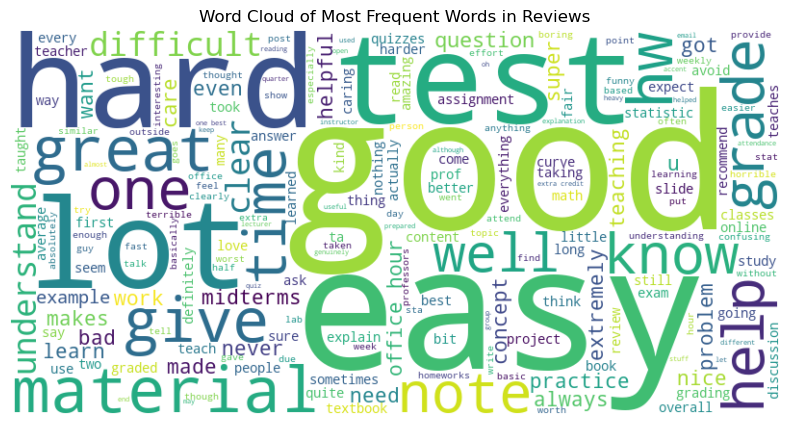

In [41]:
from collections import Counter
import pandas as pd
import plotly.express as px
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
custom_stop_words = {'class', 'lecture', 'professor', 'really', 'homework', 'take', 'final', 'lectures', 'get', 'exams', 'student', 
                     'midterm', 'students', 'stats', 'go', 'make', 'course', 'pretty', 'would', 'like', 'much' }
stop_words.update(custom_stop_words)

# Combine all reviews into a single list
all_reviews = " ".join(df_all["Reviews"].explode().astype(str)).lower()
words = [word for word in all_reviews.split() if word not in stop_words and word.isalpha()]

# Count word frequencies
word_freq = Counter(words)
df_words = pd.DataFrame(word_freq.most_common(20), columns=["Word", "Count"])

# Bar plot of most common words
fig = px.bar(df_words, x="Word", y="Count", title="Most Common Words in Reviews")
fig.show()

# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Frequent Words in Reviews")
plt.show()


In [40]:
import pandas as pd
from collections import Counter
import plotly.express as px

# Separate positive and negative reviews based on the 'Sentiment' column
df_positive = df_all[df_all["Sentiment"].apply(lambda x: 'Positive' in x)]
df_negative = df_all[df_all["Sentiment"].apply(lambda x: 'Negative' in x)]

# Combine all words from positive reviews and negative reviews
pos_words = " ".join(df_positive["Reviews"].explode()).lower().split()
neg_words = " ".join(df_negative["Reviews"].explode()).lower().split()

# Remove stopwords
stop_words = set(stopwords.words('english'))
custom_stop_words = {'class', 'lecture', 'professor', 'really', 'homework', 'take', 'final', 'lectures', 'get', 'exams', 'student', 
                     'midterm', 'students', 'stats', 'go', 'make', 'course', 'pretty', 'would', 'like', 'much' }
stop_words.update(custom_stop_words)
pos_words = [word for word in pos_words if word not in stop_words and word.isalpha()]
neg_words = [word for word in neg_words if word not in stop_words and word.isalpha()]

# Count word frequencies
pos_freq = Counter(pos_words)
neg_freq = Counter(neg_words)

# Create dataframes with the most common words
df_pos_words = pd.DataFrame(pos_freq.most_common(20), columns=["Word", "Count"])
df_neg_words = pd.DataFrame(neg_freq.most_common(20), columns=["Word", "Count"])

# Plot both word distributions
fig1 = px.bar(df_pos_words, x="Word", y="Count", title="Most Common Words in Positive Reviews", color="Count")
fig2 = px.bar(df_neg_words, x="Word", y="Count", title="Most Common Words in Negative Reviews", color="Count")

fig1.show()
fig2.show()



In [29]:
from nltk.util import ngrams

bigrams = list(ngrams(words, 2))
bigram_freq = Counter(bigrams)
df_bigrams = pd.DataFrame(bigram_freq.most_common(20), columns=["Bigram", "Count"])

# Convert tuple to readable text
df_bigrams["Bigram"] = df_bigrams["Bigram"].apply(lambda x: " ".join(x))

# Plot bigrams
fig = px.bar(df_bigrams, x="Bigram", y="Count", title="Most Common Bigrams in Reviews", color="Count")
fig.show()


In [43]:
import pandas as pd
import plotly.express as px

# Define rating categories based on Average Rating
def categorize_rating(rating):
    if rating >= 4.5:
        return "High Rating"
    elif rating >= 3.0:
        return "Medium Rating"
    else:
        return "Low Rating"

# Apply the rating category based on the Average Rating
df_all['Rating_Category'] = df_all['Average Rating'].astype(float).apply(categorize_rating)

# Exploding the Sentiment column to have individual rows for each sentiment
df_exploded = df_all.explode('Sentiment')

# Count the sentiment distribution across different rating categories
sentiment_counts = df_exploded.groupby(['Rating_Category', 'Sentiment']).size().reset_index(name='Count')

# Plot the sentiment distribution across different rating categories
fig = px.bar(sentiment_counts, x='Rating_Category', y='Count', color='Sentiment',
             title="Sentiment Distribution Based on Rating Category",
             labels={"Rating_Category": "Rating Category", "Sentiment": "Sentiment"})
fig.show()


In [49]:


# Function to calculate Positive/Negative Sentiment Ratio
def sentiment_ratio(sentiments):
    positive_count = sentiments.count('Positive')
    negative_count = sentiments.count('Negative')
    if negative_count == 0:
        return positive_count  # To avoid division by zero, return the positive count if no negative sentiments
    return positive_count / negative_count

# Apply the function to calculate the ratio for each professor
df_all['Pos_Neg_Ratio'] = df_all['Sentiment'].apply(sentiment_ratio)
df_all['Average Rating'] = df_all['Average Rating'].astype(float)

# Create scatter plot: Average Rating vs Positive/Negative Sentiment Ratio
fig = px.scatter(df_all, x='Average Rating', y='Pos_Neg_Ratio', 
                 title="Average Rating vs Positive/Negative Sentiment Ratio",
                 labels={"Average Rating": "Average Rating", "Pos_Neg_Ratio": "Positive/Negative Sentiment Ratio"},
                 color = 'School',
                 hover_data=['Professor'],
                 trendline="ols",  # Ordinary least squares regression (line of best fit)
                 trendline_scope="overall")  # Adding professor as hover data for context
fig.show()


In [50]:
df_all.to_csv("uc_rmp_reviews.csv", index=False)